In [68]:
import os
import sys
from pathlib import Path

import anndata as ad
import h5py
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [69]:
import seaborn as sns
from statannotations.Annotator import Annotator

In [70]:
print(sns.__version__)

0.12.2


In [71]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [72]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
experiment = "Lung"
cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4']
datasets = [f'{core}_{i}' for core in cores for i in range(1,5)] + ['F7_3', 'F7_4']

# experiment = "tonsil"
# cores = ["DonorA", "DonorE"]
# datasets = [core + f"_{i}" for i in range(1, 7) for core in cores]

In [74]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


# Load data

In [75]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [76]:
%%capture 

adatas = []
adatas_raw = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    # data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    
    # FPM normalize
    sc.pp.normalize_total(adata, target_sum=1e5)
    # sc.pp.log1p(adata, base=2)
    adatas_raw.append(adata.copy())
    
    # Standard scale
    sc.pp.scale(adata)
    adatas.append(adata)
    
adata = ad.concat(adatas, join="inner")
adata_raw = ad.concat(adatas_raw, join="inner")

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
   

In [77]:
# sc.pl.heatmap(adata, adata.var_names, groupby='Core', swap_axes=False, cmap='bwr', figsize=(20,10), standard_scale='obs', use_raw=False)

In [78]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [79]:
adata_IMC_cluster

AnnData object with n_obs × n_vars = 19507 × 12
    obs: 'Cell', 'Dataset', 'Core', 'leiden', 'Type', 'Region'
    uns: 'Dataset_colors', 'Region_colors', 'Type_colors', 'dendrogram_Type', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scanorama', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [80]:
adata = adata[~adata.obs.Dataset.isin(['F7_1', 'F7_2'])]
adata_IMC = adata_IMC_cluster[~adata_IMC_cluster.obs.Dataset.isin(['F7_1', 'F7_2'])]

In [81]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 14000)].index.tolist()
# mz_qc = df_sum[(df_sum > 220)].index.tolist()

In [82]:
len(mz_qc)

177

In [83]:
adata = adata[:, mz_qc]
adata_raw = adata_raw[:, mz_qc]

## Get literature lut

In [84]:
SIMS_masses = adata.var_names

In [85]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_09012022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.4
matched_dfs = []
for mz in SIMS_masses.astype(float):
    if mz < 1.1:
        continue
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
    else:
        matched = pd.DataFrame([['', '', '', '', mz]], columns=df.columns.tolist() + ['SIMS mz'])
        matched_dfs.append(matched)
matched = pd.concat(matched_dfs)

C:\Users\thu71\AppData\Local\Temp\ipykernel_2844\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched.loc[:,'SIMS mz'] = mz
C:\Users\thu71\AppData\Local\Temp\ipykernel_2844\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched.loc[:,'SIMS mz'] = mz
C:\Users\thu71\AppData\Local\Temp\ipykernel_2844\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [86]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

matched.loc[matched['Molecules'] != '', 'Molecules'] = ' ' + matched.loc[matched['Molecules'] != '', 'Molecules']
SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)
SIMS_name_subset = SIMS_name_subset

SIMS_nm_subset = SIMS_masses_subset + 'm/z' + SIMS_name_subset 

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 176


In [87]:
adata_all = adata.copy()
adata = adata[:, SIMS_masses_subset]
adata.var_names = SIMS_nm_subset

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [88]:
adata_raw = adata_raw[:, SIMS_masses_subset]
adata_raw.var_names = SIMS_nm_subset


In [89]:
IMC_labels =  adata_IMC.var_names.tolist()
SIMS_labels = adata.var_names.tolist()
labels = IMC_labels+SIMS_labels

adata_all = ad.AnnData(np.concatenate([adata_IMC.X, adata.X], axis=1))
adata_all.var_names = labels

# Correlation between protein and SIMS channels

In [90]:
from sklearn.preprocessing import LabelEncoder


In [91]:
# Get correlation matrix
df = pd.DataFrame(adata_all.X, columns=adata_all.var_names.tolist())
df_corr = df.corr()

In [92]:
print(IMC_labels)

['CD20', 'CD3', 'CD31', 'CD4', 'CD68', 'CD8', 'COL1', 'ECadherin', 'GranzymeB', 'PanKeratin', 'SMA', 'Vimentin']


In [93]:
# IMC_labels = ['CD20', 'CD21', 'CD27', 'CD3', 'CD38', 'CD4', 'COL1', 'CXCR5', 'EZH2', 'ICOS1', 'Ki67', 'Vimentin']

In [94]:
IMC_labels = ['CD20', 'CD3', 'CD31', 'CD4', 'CD68', 'CD8', 'COL1', 'ECadherin', 'GranzymeB', 'PanKeratin', 'SMA', 'Vimentin']

In [95]:
print(len(IMC_labels))

12


C:\Users\thu71\AppData\Local\Temp\ipykernel_2844\1996932828.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intensity.sort_values(by=[marker], inplace=True)
C:\Users\thu71\AppData\Local\Temp\ipykernel_2844\1996932828.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intensity.loc[:, f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop')
C:\Users\thu71\AppData\Local\Temp\ipykernel_2844\1996932828.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

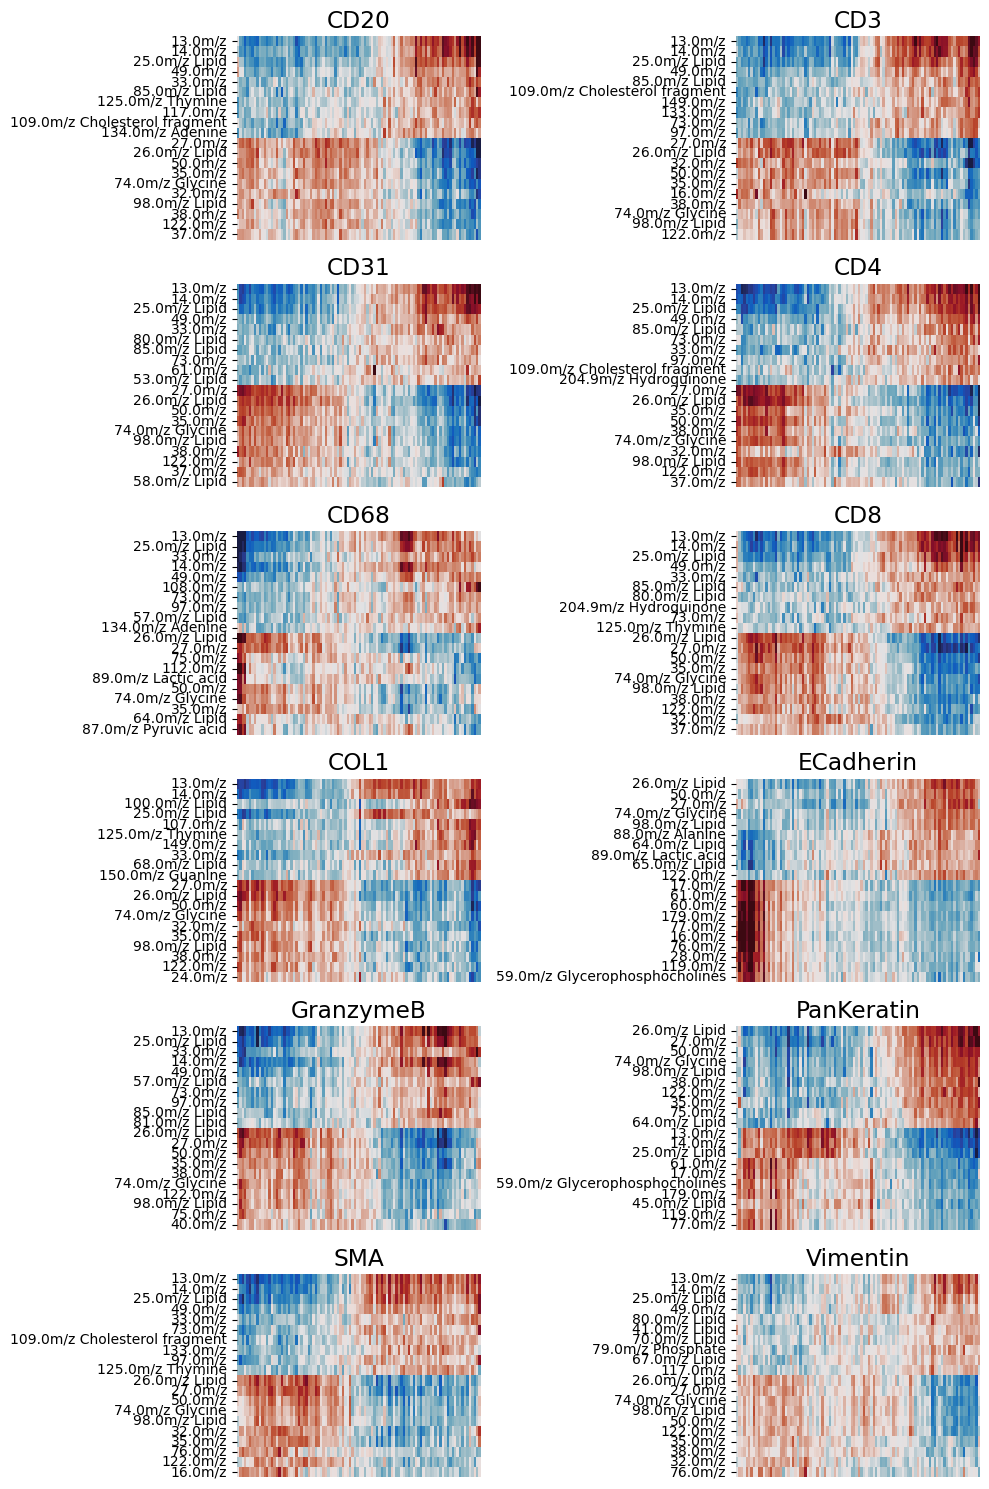

In [96]:
n = 10
n_cut = 100
n_col = 2

fig, axs = plt.subplots(len(IMC_labels)//n_col, n_col, figsize=(10,15))
for i, marker in enumerate(IMC_labels):
    # Get positive and negative correlation
    corr_pos = df_corr.loc[marker].nlargest(25).index.tolist()
    corr_neg = df_corr.loc[marker].nsmallest(25).index.tolist()

    # Get only SIMS masses
    corr_pos = [corr for corr in corr_pos if corr in SIMS_labels][:n]
    corr_neg = [corr for corr in corr_neg if corr in SIMS_labels][:n]
    corr_list = [marker] + corr_pos + corr_neg

    # Get range 
    df_intensity = df[corr_list]
    df_intensity.sort_values(by=[marker], inplace=True)
    df_intensity.loc[:, f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop') 

    LE = LabelEncoder()
    df_intensity.loc[:, f'{marker} cut'] = LE.fit_transform(df_intensity[f'{marker} cut'])

    # Get sorted dataframe
    df_sort = df_intensity.groupby(f'{marker} cut').mean()
    df_sort.drop([marker], axis=1, inplace=True)

    with sns.plotting_context('notebook', font_scale=1.4):
        ax = axs.flatten()[i]
        ax = sns.heatmap(df_sort.T, ax=ax, cmap=heatmap_cmp,
                         xticklabels=False, yticklabels=True, 
                         cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7}, 
                         vmin=-0.5, vmax=0.5,  cbar=False)
        ax.set(xlabel='')
        ax.set_title(marker)
fig.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.show()

In [97]:
glucose_frag = ['71.0m/z', '87.0m/z Pyruvic acid', '99.0m/z Lipid', '119.0m/z', '141.0m/z Lipid', '74.0m/z Glycine',  '89.0m/z Lactic acid', '122.0m/z', ]

amino_acids = ['74.0m/z Glycine',  '88.0m/z Alanine', '104.0m/z Serine', '114.0m/z Proline', 
               '116.0m/z Valine', '118.0m/z Threonine', '120.0m/z Cysteine', 
               '130.0m/z Isoleucine/leucine', '131.0m/z Asparagine', '132.0m/z Aspartic acid', 
               '145.0m/z Glutamine', '146.0m/z Glutamic acid', '164.0m/z Phenylalanine']

cholesterol_frag = ['95.0m/z Cholesterol fragment', 
                    '109.0m/z Cholesterol fragment', 
                    '147.0m/z Cholesterol fragment',
                    '161.0m/z Cholesterol fragment']

lipids = [e for e in SIMS_nm_subset if 'Lipid' in e]
FA = [e for e in SIMS_nm_subset if 'FA' in e]

In [98]:
subset = glucose_frag+amino_acids+cholesterol_frag+lipids+FA

C:\Users\thu71\AppData\Local\Temp\ipykernel_2844\920376945.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intensity.sort_values(by=[marker], inplace=True)
C:\Users\thu71\AppData\Local\Temp\ipykernel_2844\920376945.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intensity.loc[:, f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop')
C:\Users\thu71\AppData\Local\Temp\ipykernel_2844\920376945.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

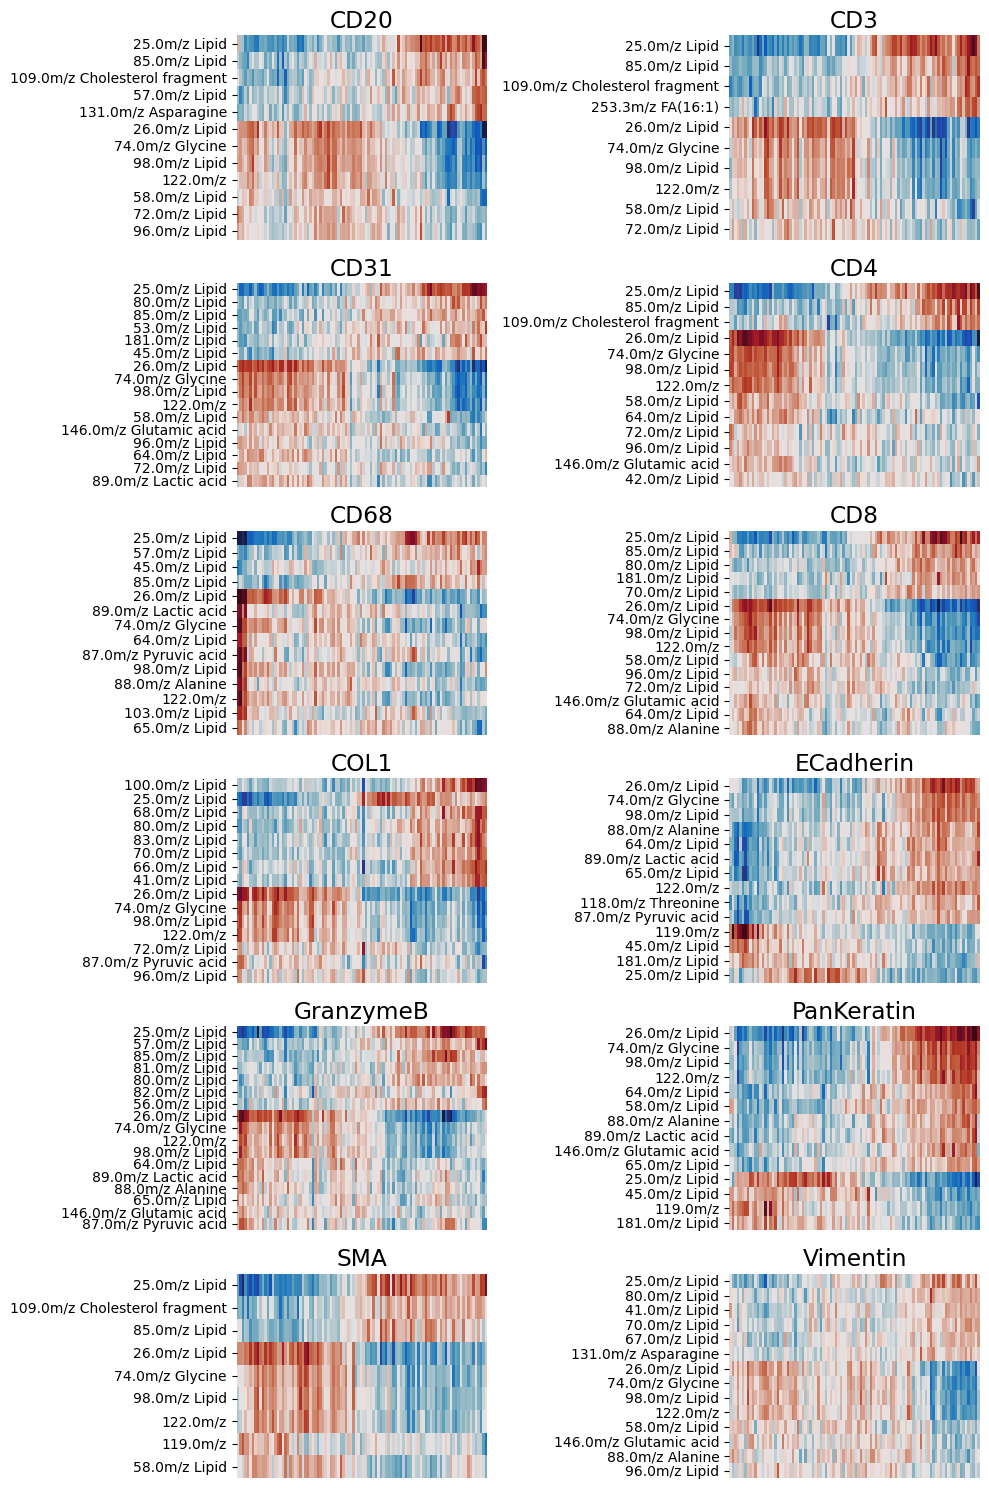

In [99]:
n = 10
n_cut = 100
n_col = 2

fig, axs = plt.subplots(len(IMC_labels)//n_col, n_col, figsize=(10,15))
for i, marker in enumerate(IMC_labels):
    # Get positive and negative correlation
    corr_pos = df_corr.loc[marker].nlargest(25).index.tolist()
    corr_neg = df_corr.loc[marker].nsmallest(25).index.tolist()

    # Get only SIMS masses
    corr_pos = [corr for corr in corr_pos if corr in subset][:n]
    corr_neg = [corr for corr in corr_neg if corr in subset][:n]
    corr_list = [marker] + corr_pos + corr_neg

    # Get range 
    df_intensity = df[corr_list]
    df_intensity.sort_values(by=[marker], inplace=True)
    df_intensity.loc[:, f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop') 

    LE = LabelEncoder()
    df_intensity.loc[:, f'{marker} cut'] = LE.fit_transform(df_intensity[f'{marker} cut'])

    # Get sorted dataframe
    df_sort = df_intensity.groupby(f'{marker} cut').mean()
    df_sort.drop([marker], axis=1, inplace=True)

    with sns.plotting_context('notebook', font_scale=1.4):
        ax = axs.flatten()[i]
        ax = sns.heatmap(df_sort.T, ax=ax, cmap=heatmap_cmp,
                         xticklabels=False, yticklabels=True, 
                         cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7}, 
                         vmin=-0.5, vmax=0.5,  cbar=False)
        ax.set(xlabel='')
        ax.set_title(marker)
fig.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.show()